In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model

from keras.applications import Xception

### **Data Pre-processing - Classification**

In [ ]:
!unzip '/content/drive/MyDrive/Queensland Dataset CE42.zip'

In [2]:
root_dir = '/content/Queensland Dataset CE42'
ftype = ['/BCC/', '/IEC/', '/SCC/']
labels = []
mask_paths = []

for i, path in enumerate(ftype):
  ldir = os.listdir(root_dir + path + 'Masks')
  for j, masks in enumerate(ldir):
    mask_paths.append(root_dir + path + 'Masks/' + masks)
    labels.append(i)

In [3]:
len(mask_paths), len(labels)

(1500, 1500)

In [4]:
df = pd.DataFrame(mask_paths, columns=['Mask_Path'])
df = df.assign(Label=labels)
df = df.astype({'Label': np.int8})
df.tail()

,Mask_Path,Label
1495,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2
1496,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2
1497,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2
1498,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2
1499,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Mask_Path  1500 non-null   object
 1   Label      1500 non-null   int8  
dtypes: int8(1), object(1)
memory usage: 13.3+ KB


In [6]:
np.random.seed(42)

shuffled_df = pd.DataFrame.sample(df, 
                                  n=len(df['Mask_Path']), 
                                  ignore_index=True)
shuffled_df.head()

,Mask_Path,Label
0,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2
1,/content/Queensland Dataset CE42/SCC/Masks/SCC...,2
2,/content/Queensland Dataset CE42/BCC/Masks/BCC...,0
3,/content/Queensland Dataset CE42/BCC/Masks/BCC...,0
4,/content/Queensland Dataset CE42/BCC/Masks/BCC...,0


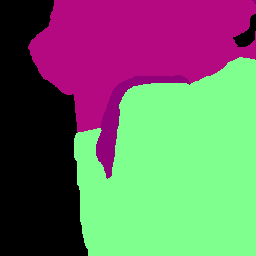

In [7]:
# testing...
mask = tf.keras.preprocessing.image.load_img(shuffled_df.loc[0].at['Mask_Path'], 
                                             color_mode='rgb',
                                             target_size=(256, 256))
mask

### **Actual Work**

In [8]:
mask_data = []
label_data = []

for index, rows in shuffled_df.iterrows():
  mask = tf.keras.preprocessing.image.load_img(shuffled_df.loc[index].at['Mask_Path'],
                                                color_mode='rgb',
                                                target_size=(256, 256))
  mask_data.append(np.array(mask))
  label_data.append(shuffled_df.loc[index].at['Label'])

In [9]:
len(mask_data), len(label_data)

(1500, 1500)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(mask_data, label_data, test_size=0.2, random_state=42)
np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

((1200, 256, 256, 3), (1200,), (300, 256, 256, 3), (300,))

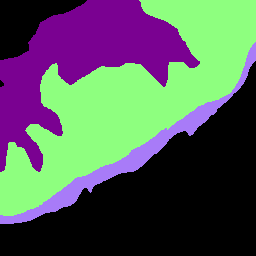

In [11]:
cv2_imshow(X_train[0])

In [12]:
# Preprocessing Masks
X_train = np.divide(X_train, 255.0, dtype=np.float64)
X_test = np.divide(X_test, 255.0, dtype=np.float64)
X_train.shape, X_test.shape

((1200, 256, 256, 3), (300, 256, 256, 3))

In [13]:
# Label one hot encoding - Didn't run - going for SparseCategoricalCrossentropy concept
y_train = tf.one_hot(y_train, depth=3)
y_test = tf.one_hot(y_test, depth=3)
np.shape(y_train), np.shape(y_test)

(TensorShape([1200, 3]), TensorShape([300, 3]))

### **Model Implementation - Classification**

In [14]:
model = Xception(include_top=False,
                 input_shape=(256, 256, 3))
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [15]:
for layer in model.layers[86:]:
  layer.trainable = False

for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [16]:
# Creating our model head
x = model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(3, activation = 'softmax')(x)

transfer_model = tf.keras.Model(inputs=model.input, outputs=x)

In [ ]:
plot_model(model, show_shapes=True)

In [19]:
# defining callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/classification-ESP-DIP/Xception_1_layers(86_false), bs-15_adam(3).hdf5', # /content/drive/MyDrive/classification-ESP-DIP
                             monitor='val_accuracy',
                             mode='max', save_best_only=True, verbose=1)
earlystopping_val_acc = EarlyStopping(monitor='val_accuracy', patience=12, 
                                      restore_best_weights=True)
earlystopping_val_loss = EarlyStopping(monitor='val_loss', patience=12, 
                                       restore_best_weights=True)

In [20]:
transfer_model.compile(loss='categorical_crossentropy', 
                       optimizer= 'adam',
                       metrics=['accuracy'])

In [21]:
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape

((1200, 256, 256, 3), (300, 256, 256, 3), (1200, 3), (300, 3))

In [22]:
history = transfer_model.fit(X_train, np.array(y_train),
                             batch_size=15,
                             epochs=100,
                             shuffle=True,
                             validation_data=(X_test, np.array(y_test)),
                             callbacks=[earlystopping_val_acc,
                                        earlystopping_val_loss,
                                        checkpoint])

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 2.0818 - accuracy: 0.3508
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to /content/drive/MyDrive/classification-ESP-DIP/Xception_1_layers(86_false), bs-15_adam(3).hdf5
80/80 [==============================] - 74s 597ms/step - loss: 2.0818 - accuracy: 0.3508 - val_loss: 1.1449 - val_accuracy: 0.3000
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 1.0209 - accuracy: 0.5125
Epoch 2: val_accuracy improved from 0.30000 to 0.42667, saving model to /content/drive/MyDrive/classification-ESP-DIP/Xception_1_layers(86_false), bs-15_adam(3).hdf5
80/80 [==============================] - 43s 546ms/step - loss: 1.0209 - accuracy: 0.5125 - val_loss: 1.2086 - val_accuracy: 0.4267
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.5608
Epoch 3: val_accuracy improved from 0.42667 to 0.57333, saving model to /content/drive/MyDrive/classification-ESP-DIP/Xcep

In [19]:
transfer_model.load_weights('/content/drive/MyDrive/classification-ESP-DIP/Xception_1_layers(86_false), bs-20_adam.hdf5')

In [23]:
y_preds = transfer_model.predict(X_test)

10/10 [==============================] - 6s 257ms/step


In [24]:
# memory management
X_train = None
y_train = None

In [ ]:
y_pred_c = np.argmax(y_preds, axis=1)
y_test_c = np.argmax(y_test, axis=1)

In [29]:
np.array(y_test).shape, y_preds.shape

((300, 3), (300, 3))

In [31]:
cm = confusion_matrix(y_test_c, y_pred_c)
cm

array([[79, 24,  4],
       [16, 81,  4],
       [12, 25, 55]])

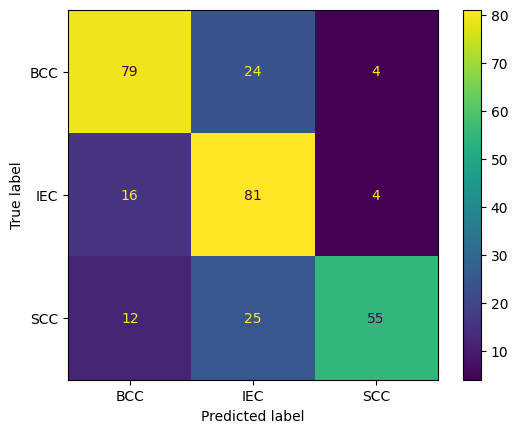

In [32]:
disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test_c, y_pred_c) ,display_labels=['BCC','IEC','SCC'])
disp_cm.plot()
plt.show()